<a href="https://colab.research.google.com/github/smohanna/EAEE4000_Rainfall_Intensity/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brazil Extreme Rainfall Intensity Forecaster (B-ERIF): Recalibrating IFD Curves

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor


In [5]:
import pandas as pd

caminho_flood = "/content/drive/MyDrive/chuva_RS_chirps_maio2024.csv"

tmp = pd.read_csv(caminho_flood, nrows=5)
print(tmp.columns)
tmp.head()


Index(['time', 'x', 'y', 'precipitation'], dtype='object')


,time,x,y,precipitation
0,2023-01-01,-51.225,-29.975,0.0
1,2023-01-02,-51.225,-29.975,0.0
2,2023-01-03,-51.225,-29.975,0.0
3,2023-01-04,-51.225,-29.975,0.0
4,2023-01-05,-51.225,-29.975,0.0


In [6]:
# histórico (já está ok)
df_hist = pd.read_csv(
    "/content/drive/MyDrive/chuva_RS_chirps_2000_2024.csv",
    parse_dates=['date']
)

# enchente (janela de maio/2024) – usa 'time' e depois renomeia
df_flood = pd.read_csv(
    "/content/drive/MyDrive/chuva_RS_chirps_maio2024.csv",
    parse_dates=['time']      # <<< muda aqui
)

df_flood = df_flood.rename(columns={
    'time': 'date',           # padroniza para ser igual ao histórico
    'pr':   'rain_mm'         # se a coluna de chuva se chamar 'pr'
})

print("Histórico:", df_hist['date'].min().date(), "→", df_hist['date'].max().date())
print("Enchente:", df_flood['date'].min().date(), "→", df_flood['date'].max().date())
print("Formato histórico:", df_hist.shape)
print("Formato enchente:", df_flood.shape)



Histórico: 2000-01-01 → 2024-05-31
Enchente: 2023-01-01 → 2024-05-31
Formato histórico: (158677974, 7)
Formato enchente: (517, 4)


2. Construir a variável alvo: máximo diário anual (por grade)

In [8]:
# garantir colunas de tempo no histórico
df_hist['year']  = df_hist['date'].dt.year
df_hist['month'] = df_hist['date'].dt.month
df_hist['day']   = df_hist['date'].dt.dayofyear

# máximo diário anual por grade (x, y)
annual_max = (
    df_hist
    .groupby(['year', 'y', 'x'])['rain_mm']
    .max()
    .reset_index()
    .rename(columns={'rain_mm': 'rain_max'})
)

annual_max.head(), annual_max.shape


(   year       y       x   rain_max
 0  2000 -34.025 -56.975  63.062610
 1  2000 -34.025 -56.925  64.952354
 2  2000 -34.025 -56.875  67.107660
 3  2000 -34.025 -56.825  80.722790
 4  2000 -34.025 -56.775  82.069220,
 (444825, 4))

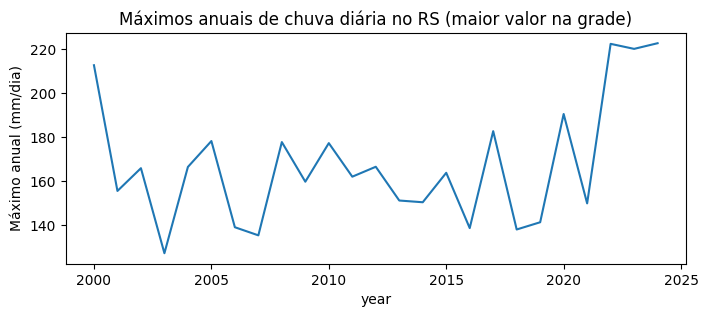

In [9]:
annual_max.groupby('year')['rain_max'].max().plot(figsize=(8,3))
plt.ylabel("Máximo anual (mm/dia)")
plt.title("Máximos anuais de chuva diária no RS (maior valor na grade)");


3. Definir features, target e splits (train/val/test)

In [10]:
features = ['x', 'y', 'year']
target   = 'rain_max'

X = annual_max[features]
y = annual_max[target]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

X_train.shape, X_val.shape, X_test.shape


((311377, 3), (66724, 3), (66724, 3))

4. Função utilitária para avaliar modelos (corrigida)

In [11]:
def evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    # treina
    model.fit(X_train, y_train)

    # previsões
    y_pred_train = model.predict(X_train)
    y_pred_val   = model.predict(X_val)
    y_pred_test  = model.predict(X_test)

    # RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val   = np.sqrt(mean_squared_error(y_val,   y_pred_val))
    rmse_test  = np.sqrt(mean_squared_error(y_test,  y_pred_test))

    # R2
    r2_train = r2_score(y_train, y_pred_train)
    r2_val   = r2_score(y_val,   y_pred_val)
    r2_test  = r2_score(y_test,  y_pred_test)

    return {
        'model': name,
        'rmse_train': rmse_train,
        'rmse_val':   rmse_val,
        'rmse_test':  rmse_test,
        'r2_train':   r2_train,
        'r2_val':     r2_val,
        'r2_test':    r2_test
    }


5. Rodar DecisionTree, RandomForest, XGBoost, MLP (com hiperparâmetros)

In [12]:
results = []

# 1) Decision Tree (regression tree)
tree = DecisionTreeRegressor(
    max_depth=5,
    min_samples_leaf=5,
    random_state=42
)
results.append(evaluate_model("DecisionTree", tree,
                              X_train, y_train, X_val, y_val, X_test, y_test))

# 2) Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
results.append(evaluate_model("RandomForest", rf,
                              X_train, y_train, X_val, y_val, X_test, y_test))

# 3) XGBoost
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)
results.append(evaluate_model("XGBoost", xgb,
                              X_train, y_train, X_val, y_val, X_test, y_test))

# 4) MLP (Neural Network fully-connected)
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),   # neurônios e camadas
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,      # learning rate
    max_iter=500,
    random_state=42
)
results.append(evaluate_model("MLP", mlp,
                              X_train, y_train, X_val, y_val, X_test, y_test))


6. Tabela final de comparação (com melhor modelo em negrito)

In [13]:
results_df = pd.DataFrame(results)

# índice do melhor modelo (menor RMSE em teste)
best_idx = results_df['rmse_test'].idxmin()
best_name = results_df.loc[best_idx, 'model']

# deixar o nome em **negrito** só na coluna model
results_df_display = results_df.copy()
results_df_display.loc[best_idx, 'model'] = f"**{best_name}**"

from IPython.display import HTML
HTML(results_df_display.round(3).to_html(escape=False, index=False))


model,rmse_train,rmse_val,rmse_test,r2_train,r2_val,r2_test
DecisionTree,16.735,16.682,16.776,0.239,0.242,0.241
**RandomForest**,11.755,11.871,11.885,0.625,0.616,0.619
XGBoost,12.982,13.156,13.120,0.542,0.528,0.536
MLP,18.566,18.514,18.620,0.064,0.066,0.065


7.1 LSTM temporal – série diária em um ponto do RS

7.1.1 Selecionar um ponto e montar a série diária

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# garante que df_hist está ordenado
df_hist = df_hist.sort_values('date')

# escolhe um ponto de referência na região de enchente (ajusta se quiser)
x0, y0 = -49.0, -29.0

# acha a célula de grade mais próxima desse ponto
idx_min = ((df_hist['x'] - x0)**2 + (df_hist['y'] - y0)**2).idxmin()
x_sel = df_hist.loc[idx_min, 'x']
y_sel = df_hist.loc[idx_min, 'y']

print("Ponto escolhido:", x_sel, y_sel)

# filtra apenas esse ponto
df_point = (
    df_hist[(df_hist['x'] == x_sel) & (df_hist['y'] == y_sel)]
    .sort_values('date')
    [['date', 'rain_mm']]
    .reset_index(drop=True)
)

df_point.head(), df_point['date'].min(), df_point['date'].max()


Ponto escolhido: -49.175 -28.825


(        date  rain_mm
 0 2000-01-01      0.0
 1 2000-01-02      0.0
 2 2000-01-03      0.0
 3 2000-01-04      0.0
 4 2000-01-05      0.0,
 Timestamp('2000-01-01 00:00:00'),
 Timestamp('2024-05-31 00:00:00'))

7.1.2 Criar janelas (window) para LSTM

In [15]:
from sklearn.preprocessing import MinMaxScaler

series = df_point['rain_mm'].astype('float32').values
dates  = df_point['date'].values

scaler_lstm = MinMaxScaler()
series_scaled = scaler_lstm.fit_transform(series.reshape(-1, 1)).flatten()

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window = 30  # 30 dias de histórico
X_lstm, y_lstm = create_sequences(series_scaled, window)

# adiciona dimensão de "features" para LSTM: (amostras, time_steps, features)
X_lstm = X_lstm[..., np.newaxis]

N = len(X_lstm)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)

X_train_l, y_train_l = X_lstm[:train_size], y_lstm[:train_size]
X_val_l,   y_val_l   = X_lstm[train_size:train_size+val_size], y_lstm[train_size:train_size+val_size]
X_test_l,  y_test_l  = X_lstm[train_size+val_size:], y_lstm[train_size+val_size:]

X_train_l.shape, X_val_l.shape, X_test_l.shape


((6221, 30, 1), (1333, 30, 1), (1334, 30, 1))

7.1.3 Definir e treinar o LSTM

In [16]:
tf.random.set_seed(42)

lstm_model = models.Sequential([
    layers.Input(shape=(window, 1)),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

history_lstm = lstm_model.fit(
    X_train_l, y_train_l,
    validation_data=(X_val_l, y_val_l),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 9/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 10/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 11/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 12/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 

7.1.4 Avaliação + gráfico

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_test_l = lstm_model.predict(X_test_l).flatten()

# desfaz normalização
y_test_inv = scaler_lstm.inverse_transform(y_test_l.reshape(-1, 1)).flatten()
y_pred_inv = scaler_lstm.inverse_transform(y_pred_test_l.reshape(-1, 1)).flatten()

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2_lstm   = r2_score(y_test_inv, y_pred_inv)

rmse_lstm, r2_lstm


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


(np.float64(10.283851364005274), 0.025883376598358154)

Plot

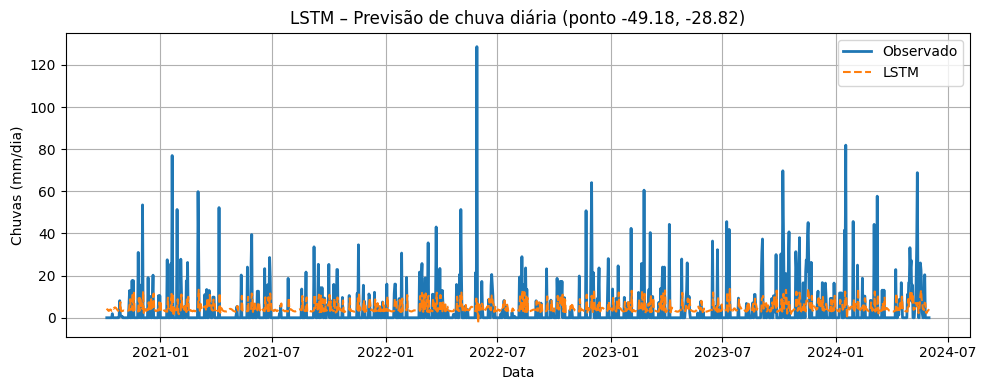

In [18]:
# datas correspondentes à parte de teste
test_start_idx = len(series) - len(y_test_inv)
dates_test = dates[test_start_idx:]

plt.figure(figsize=(10, 4))
plt.plot(dates_test, y_test_inv, label='Observado', linewidth=2)
plt.plot(dates_test, y_pred_inv, label='LSTM', linestyle='--')
plt.title(f"LSTM – Previsão de chuva diária (ponto {round(x_sel,2)}, {round(y_sel,2)})")
plt.ylabel("Chuvas (mm/dia)")
plt.xlabel("Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
lstm_row = pd.DataFrame([{
    'model': 'LSTM_point',
    'rmse_train': np.nan,
    'rmse_val':   np.nan,
    'rmse_test':  rmse_lstm,
    'r2_train':   np.nan,
    'r2_val':     np.nan,
    'r2_test':    r2_lstm
}])

results_df = pd.concat([results_df, lstm_row], ignore_index=True)
results_df


,model,rmse_train,rmse_val,rmse_test,r2_train,r2_val,r2_test
0,DecisionTree,16.734927,16.681535,16.775891,0.239193,0.241947,0.240800
1,RandomForest,11.755126,11.870970,11.884549,0.624611,0.616116,0.618978
2,XGBoost,12.981584,13.156264,13.120413,0.542193,0.528488,0.535613
3,MLP,18.566105,18.514060,18.620409,0.063584,0.066249,0.064673
4,LSTM_point,NaN,NaN,10.283851,NaN,NaN,0.025883


7.2 CNN espacial simples – “imagem” de chuva por dia

7.2.1 Montar cubos 2D de chuva

In [21]:
# recorta um período mais curto para a CNN (opcional)
df_cnn = df_hist.copy()
# df_cnn = df_cnn[(df_cnn['date'].dt.year >= 2010) & (df_cnn['date'].dt.year <= 2020)]

xs = np.sort(df_cnn['x'].unique())
ys = np.sort(df_cnn['y'].unique())

nx, ny = len(xs), len(ys)
nx, ny


(160, 141)

In [22]:
grouped = df_cnn.groupby('date')

# threshold de extremo (ex: 95º percentil de chuva)
threshold = df_cnn['rain_mm'].quantile(0.95)
threshold


np.float64(27.427603)

In [23]:
X_imgs = []
y_labels = []
dates_img = []

for date, g in grouped:
    # matriz 2D [lat, lon]
    img = g.pivot(index='y', columns='x', values='rain_mm') \
           .reindex(index=ys, columns=xs) \
           .fillna(0.0) \
           .values

    X_imgs.append(img)
    y_labels.append(1 if g['rain_mm'].max() >= threshold else 0)
    dates_img.append(date)

X_imgs = np.array(X_imgs)[..., np.newaxis]  # adiciona canal
y_labels = np.array(y_labels)

X_imgs.shape, y_labels.shape, y_labels.mean()  # proporção de extremos


((8918, 141, 160, 1), (8918,), np.float64(0.5300515810719892))

In [24]:
# amostra aleatória de 800 dias pra ficar mais leve
np.random.seed(42)
idx_sample = np.random.choice(len(X_imgs), size=min(800, len(X_imgs)), replace=False)
X_imgs = X_imgs[idx_sample]
y_labels = y_labels[idx_sample]


7.2.2 Train/val/test para CNN

In [25]:
from sklearn.model_selection import train_test_split

X_train_i, X_temp_i, y_train_i, y_temp_i = train_test_split(
    X_imgs, y_labels, test_size=0.3, random_state=42, stratify=y_labels
)
X_val_i, X_test_i, y_val_i, y_test_i = train_test_split(
    X_temp_i, y_temp_i, test_size=0.5, random_state=42, stratify=y_temp_i
)

X_train_i.shape, X_val_i.shape, X_test_i.shape


((560, 141, 160, 1), (120, 141, 160, 1), (120, 141, 160, 1))

7.2.3 Definir CNN e treinar

In [26]:
cnn_model = models.Sequential([
    layers.Input(shape=(ny, nx, 1)),
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_cnn = cnn_model.fit(
    X_train_i, y_train_i,
    validation_data=(X_val_i, y_val_i),
    epochs=10,
    batch_size=16,
    verbose=1
)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6958 - loss: 1.9156 - val_accuracy: 0.8417 - val_loss: 0.3198
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8825 - loss: 0.2668 - val_accuracy: 0.8667 - val_loss: 0.2431
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9093 - loss: 0.1794 - val_accuracy: 0.9083 - val_loss: 0.2143
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9576 - loss: 0.1021 - val_accuracy: 0.9083 - val_loss: 0.2308
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9773 - loss: 0.0483 - val_accuracy: 0.9000 - val_loss: 0.2610
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9944 - loss: 0.0299 - val_accuracy: 0.9167 - val_loss: 0.2695
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9964 - loss: 0.0100 - val_accuracy: 0.9083 - val_loss: 0.3102
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9167 - 

7.2.4 Avaliação + heatmap

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_proba = cnn_model.predict(X_test_i).flatten()
y_pred_cnn   = (y_pred_proba >= 0.5).astype(int)

print(classification_report(y_test_i, y_pred_cnn))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        57
           1       0.91      0.92      0.91        63

    accuracy                           0.91       120
   macro avg       0.91      0.91      0.91       120
weighted avg       0.91      0.91      0.91       120



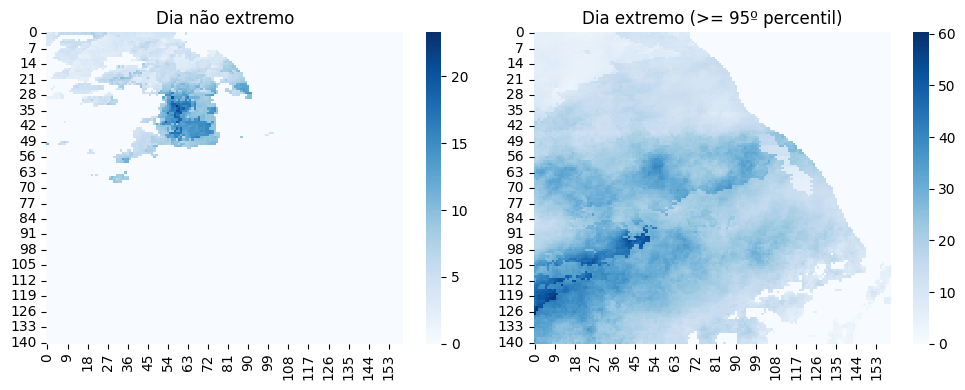

In [28]:
import seaborn as sns

# pega um dia extremo e um dia não extremo
idx_extreme = np.where(y_test_i == 1)[0][0]
idx_normal  = np.where(y_test_i == 0)[0][0]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap(X_test_i[idx_normal, ..., 0], cmap='Blues')
plt.title("Dia não extremo")

plt.subplot(1,2,2)
sns.heatmap(X_test_i[idx_extreme, ..., 0], cmap='Blues')
plt.title("Dia extremo (>= 95º percentil)")
plt.tight_layout()
plt.show()


7.3 VAE generativo simples – distribuição de máximos anuais

7.3.1 Preparar dados

In [29]:
from sklearn.preprocessing import MinMaxScaler

rain_max_vals = annual_max['rain_max'].values.astype('float32').reshape(-1,1)
scaler_vae = MinMaxScaler()
rain_scaled = scaler_vae.fit_transform(rain_max_vals)

rain_scaled.shape


(444825, 1)

7.3.2 Definir VAE em Keras

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from keras import ops   # Keras 3 ops

latent_dim = 2

# ---------------- Encoder ----------------
inputs = layers.Input(shape=(1,))
h = layers.Dense(16, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

# ---------------- Decoder ----------------
latent_inputs = layers.Input(shape=(latent_dim,))
h_dec = layers.Dense(16, activation='relu')(latent_inputs)
outputs = layers.Dense(1, activation='sigmoid')(h_dec)

decoder = Model(latent_inputs, outputs, name="decoder")

# ---------------- VAE completo ----------------
z_mean_out, z_log_var_out, z_out = encoder(inputs)
outputs_vae = decoder(z_out)

vae = Model(inputs, outputs_vae, name="vae")

# -------- Loss usando keras.ops (ESSA É A PARTE QUE QUEBRAVA) --------
# reconstruction loss: MSE entre entrada e saída
reconstruction_loss = ops.mean(ops.square(inputs - outputs_vae))

# KL divergence
kl_loss = -0.5 * ops.mean(
    1 + z_log_var_out - ops.square(z_mean_out) - ops.exp(z_log_var_out)
)

vae_loss = reconstruction_loss + kl_loss
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
vae.summary()


NotImplementedError: 

Loss (reconstrução + KL):

In [33]:
# reconstruction loss: MSE entre entrada e saída
reconstruction_loss = ops.mean(ops.square(inputs - outputs_vae))

# KL divergence term
kl_loss = -0.5 * ops.mean(
    1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var)
)

vae_loss = reconstruction_loss + kl_loss
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
vae.summary()



NotImplementedError: 

7.3.3 Treinar e gerar amostras sintéticas

In [ ]:
history_vae = vae.fit(
    rain_scaled,
    epochs=50,
    batch_size=64,
    verbose=1
)


In [ ]:
# amostra pontos no espaço latente
z_samples = np.random.normal(size=(1000, latent_dim)).astype('float32')
rain_gen_scaled = decoder.predict(z_samples)
rain_gen = scaler_vae.inverse_transform(rain_gen_scaled)

rain_gen[:10].flatten()


7.3.4 Gráfico para apresentação (distribuição real x VAE)

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(rain_max_vals.flatten(), bins=30, alpha=0.6, label='Observado')
plt.hist(rain_gen.flatten(), bins=30, alpha=0.6, label='VAE gerado')
plt.xlabel("Máximo anual de chuva (mm/dia)")
plt.ylabel("Frequência")
plt.title("VAE – Distribuição de máximos anuais observados vs gerados")
plt.legend()
plt.tight_layout()
plt.show()
